## Лабораторная работа

**Студенты:** Коршунова Анастасия, Деркач Алёна

In [65]:
# pip install imgaug
# pip install torchvision

## **1. Подготовка данных**

В данной лабораторной работе мы будем использовать следующий <a href="https://www.kaggle.com/datasets/ryanbadai/clothes-dataset">датасет с kaggle</a>.
В данном датасете `15` папок по `500` фотографий различной одежды:

            Blazer          Пиджак             
            Coat            Пальто             
            Dress           Платье             
            Hoodie          Толстовка          
            Jacket          Куртка             
            Jaket_Denim     Джинсовая куртка   
            Jacket_Sports   Спортивная куртка  
            Jeans           Джинсы             
            Pants           Штаны              
            Polo            Поло               
            Shirt           Рубашка            
            Shorts          Шорты              
            Skirt           Юбка               
            T-shirt         Футболка           
            Sweater         Свитер             

Разрешение фотографий `720х1280`. Формат `jpg`. Для того, чтобы научиться классифицировать предметы одежды нам будет достаточно этих 15 классов.

Для задачи классификации изображений хорошо подходят модели из `torchvision.models`, например `EfficientNet-B0`.

В нашей лабораторной мы будем использовать именно её.
- Cовременная и эффективная архитектура, которая обеспечивает высокую точность при относительно небольшом количестве параметров.
- Она легче, чем `ResNet50`, но при этом показывает сравнимую или даже лучшую точность на многих задачах.
- `EfficientNet` оптимизирована для работы на устройствах с ограниченными ресурсами, что делает её хорошим выбором для мобильного использования.

Нам важна как точность, так и скорость, так как потом модель будет использоваться на мобильном телефоне. 

Также модель принимает изображения размером 224x224, поэтому нам нужно будет изменить размер изображений.

Перед обучением модели выполним следующее:
- **Аугментации**
- **Изменение размера изображений**
- **Нормализация** 

In [16]:
# Библиотеки, которые мы будем использовать
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

import imgaug.augmenters as iaa
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

from torch.nn.functional import one_hot
from collections import defaultdict

In [2]:
data_dir = "Clothes_Dataset"

#### **Шаг 1: Аугментация**

Начнём с аугментации. Аугментация добавит разнообразия в классы и поможет можели лучше обучиться. Мы добавим по 200 изображений в папку каждого класса. Так мы сможем наглядно оценить как изменились изображения.

In [ ]:
import os
import random

augmentation = iaa.Sequential([
    iaa.Sometimes(0.5, iaa.Fliplr(0.5)),  # Отражение по горизонтали с вероятностью 50%
    iaa.Sometimes(0.3, iaa.Affine(
        rotate=(-30, 30),  # Случайные повороты от -30 до 30 градусов
        scale=(0.8, 1.2)  # Случайное масштабирование
    )),
    iaa.Invert(0.3), # Инверсия цвета
    iaa.ChannelShuffle(0.35), # Перемешивание канало
    iaa.Sometimes(0.3, iaa.Cutout(nb_iterations=2)), # Вырезаем 2 квадратика из изображения
    iaa.Sometimes(0.3, iaa.Dropout2d(p=0.5)), # Смена цвета изображения
    iaa.Sometimes(0.3, iaa.Crop(percent=(0, 0.05))),  # Случайные обрезки
    iaa.Sometimes(0.3, iaa.GaussianBlur(sigma=(0, 1.0))),  # Размытие
    iaa.Sometimes(0.3, iaa.AdditiveGaussianNoise(scale=(0, 0.20 * 255))),  # Гауссов шум
    iaa.Sometimes(0.3, iaa.MultiplyBrightness((0.8, 1.2))),  # Изменение яркости
    iaa.Sometimes(0.3, iaa.MultiplySaturation((0.8, 1.2))),  # Изменение насыщенности
])

def add_augmented_images(class_dir, num_augmented=200):
    # Получаем список всех изображений в папке
    images = [img for img in os.listdir(class_dir) if img.endswith(('.jpg', '.jpeg', '.png'))]
    
    # Выбираем случайные 200 изображений
    selected_images = random.sample(images, min(num_augmented, len(images)))
    
    for img_name in selected_images:
        img_path = os.path.join(class_dir, img_name)
        image = Image.open(img_path)
        
        image_np = np.array(image)
        
        # Применяем аугментацию
        augmented_image_np = augmentation(image=image_np)

        augmented_image = Image.fromarray(augmented_image_np)
        
        # Сохраняем аугментированное изображение
        new_img_name = f"aug_{img_name}"
        new_img_path = os.path.join(class_dir, new_img_name)
        augmented_image.save(new_img_path)

In [ ]:
import time

start = time.time()
for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    if os.path.isdir(class_dir):
        print(f"Добавляем аугментированные изображения для класса: {class_name}")
        add_augmented_images(class_dir)
end = time.time()

print(f'''
===========================================
Аугментация завершена!
Время: {(end - start):.2f} секунд
================================================''')

Добавляем аугментированные изображения для класса: Blazer
Добавляем аугментированные изображения для класса: Coat
Добавляем аугментированные изображения для класса: Dress
Добавляем аугментированные изображения для класса: Hoodie
Добавляем аугментированные изображения для класса: Jacket
Добавляем аугментированные изображения для класса: Jacket_Sports
Добавляем аугментированные изображения для класса: Jaket_Denim
Добавляем аугментированные изображения для класса: Jeans
Добавляем аугментированные изображения для класса: Pants
Добавляем аугментированные изображения для класса: Polo
Добавляем аугментированные изображения для класса: Shirt
Добавляем аугментированные изображения для класса: Shorts
Добавляем аугментированные изображения для класса: Skirt
Добавляем аугментированные изображения для класса: Sweater
Добавляем аугментированные изображения для класса: T-shirt

Аугментация завершена!
Время: 281.12 секунд


#### **Шаг 2: Загрузка данных**

Загрузим наши данные и сразу нормализуем их. Обычно используется нормализация с параметрами:
- Среднее: [0.485, 0.456, 0.406]
- Стандартное отклонение: [0.229, 0.224, 0.225]

Эти значения соответствуют статистике `ImageNet` (крупномасштабная база данных аннотированных изображений), на которой предобучена модель, которую мы будем использовать.

In [3]:
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Изменение размера
    transforms.ToTensor(),  # Преобразование в тензор
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Нормализация
])

dataset = ImageFolder(root=data_dir, transform=data_transform)

In [4]:
print(f'''
Общее количество изображений: {len(dataset)}
Количество классов: {len(dataset.classes)}
Пример метки и изображения: {dataset[0][1]}, {dataset[0][0].shape}''')


Общее количество изображений: 10500
Количество классов: 15
Пример метки и изображения: 0, torch.Size([3, 224, 224])


#### **Шаг 3: Разделение данных**

Разделим наши данные на 3 выборки: тренировочную (70%), валидационную (15%) и тестовую (15%).

In [5]:
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [6]:
print(f'''
Тренировочная выборка: {len(train_dataset)} изображений
Валидационная выборка: {len(val_dataset)} изображений
Тестовая выборка: {len(test_dataset)} изображений''')


Тренировочная выборка: 7349 изображений
Валидационная выборка: 1575 изображений
Тестовая выборка: 1576 изображений


#### **Проверка**

Теперь посмотрим какие изображения в тренировочной выборке мы получили. Все изображения размером 240х240 пикселей. Также видно несколько аугментированных изображений:
- (1,1) - смена цвета
- (1,2) - приближено
- (1,3) - инверсия
- (2,1) - смена цвета
- (2,5) - ругулировка каналов
- (3,2) - поворот и регулировка каналов

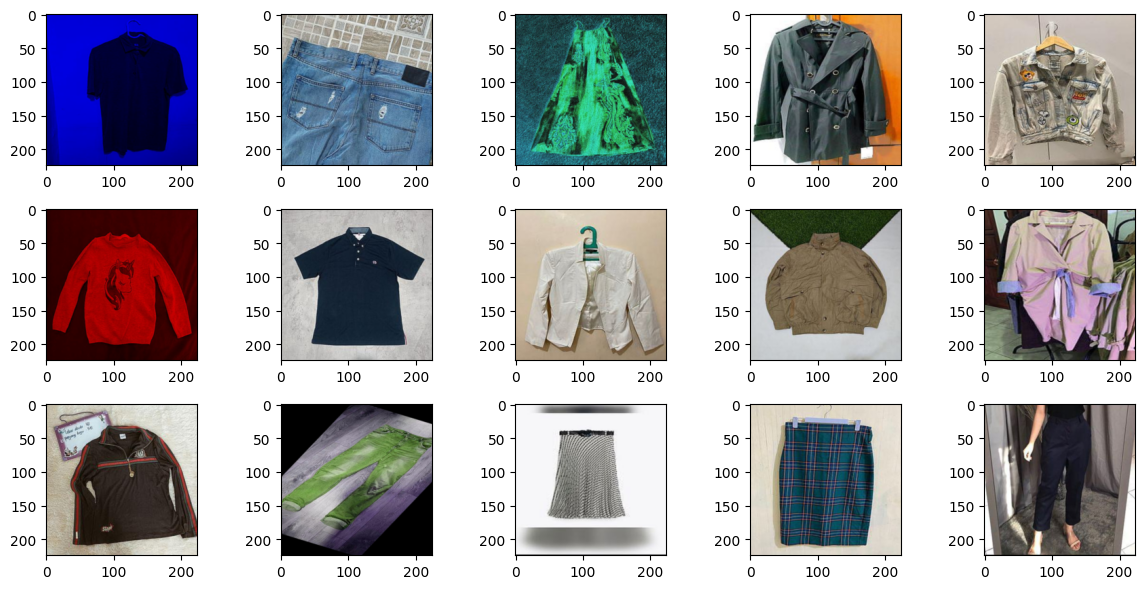

In [358]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

def denormalize(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    image = image.clone()
    for i in range(3):
        image[i] = image[i] * std[i] + mean[i]
    image = image.numpy().transpose((1, 2, 0))
    image = np.clip(image, 0, 1)
    return image

data_iter = iter(train_loader)
images, labels = next(data_iter)

fig, axes = plt.subplots(3, 5, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    if i < len(images):
        image = denormalize(images[i]) # Денормализуем изображение
        ax.imshow(image)
plt.tight_layout()
plt.show()

## **2. Выбор модели**

Заменим последний полносвязный слой (classifier), чтобы он соответствовал количеству классов в нашем датасете. У нас 15 классов, поэтому выходной слой должен иметь 15 нейронов.

Мы загрузим EfficientNet-B0 с весами, предобученными на ImageNet. Это ускорит обучение и улучшит качество модели.

In [17]:
import torchvision.models as models

model = models.efficientnet_b0(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 15) # Замена последнего слоя на 15 классов

На начальном этапе заморозим все слои, кроме последнего, чтобы обучить только его. Это позволит нам оптимизировать веса последнего слоя, не меняя весов более глубоких слоев.

In [7]:
for param in model.parameters():
    param.requires_grad = False  # Замораживаем все слои
for param in model.classifier.parameters():
    param.requires_grad = True  # Размораживаем последний слой

In [ ]:
# Функция для проверки какие слои заморожены/разморожены
def print_frozen_layers(model):
    count = 1
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"{count}. Слой '{name}' разморожен")
            count += 1
        else:
            print(f"{count}. Слой '{name}' заморожен")
            count += 1

In [9]:
print_frozen_layers(model)

1. Слой 'features.0.0.weight' заморожен
2. Слой 'features.0.1.weight' заморожен
3. Слой 'features.0.1.bias' заморожен
4. Слой 'features.1.0.block.0.0.weight' заморожен
5. Слой 'features.1.0.block.0.1.weight' заморожен
6. Слой 'features.1.0.block.0.1.bias' заморожен
7. Слой 'features.1.0.block.1.fc1.weight' заморожен
8. Слой 'features.1.0.block.1.fc1.bias' заморожен
9. Слой 'features.1.0.block.1.fc2.weight' заморожен
10. Слой 'features.1.0.block.1.fc2.bias' заморожен
11. Слой 'features.1.0.block.2.0.weight' заморожен
12. Слой 'features.1.0.block.2.1.weight' заморожен
13. Слой 'features.1.0.block.2.1.bias' заморожен
14. Слой 'features.2.0.block.0.0.weight' заморожен
15. Слой 'features.2.0.block.0.1.weight' заморожен
16. Слой 'features.2.0.block.0.1.bias' заморожен
17. Слой 'features.2.0.block.1.0.weight' заморожен
18. Слой 'features.2.0.block.1.1.weight' заморожен
19. Слой 'features.2.0.block.1.1.bias' заморожен
20. Слой 'features.2.0.block.2.fc1.weight' заморожен
21. Слой 'features.2.0.

Также сохраним всю модель (архитектуру + веса) в файл model.pth, чтобы ускорить работу. 

In [10]:
torch.save(model, "model.pth")

## **3. Настройка обучения**

Будем использовать шедулер `ReduceLROnPlateau`. Этот шедулер уменьшает learning rate, если качество модели (например, loss на валидационной выборке) перестает улучшаться. Это помогает модели выйти из локальных минимумов и улучшить качество.

In [11]:
criterion = nn.CrossEntropyLoss()

Также будем использовать раннюю остановку с терпением 5 эпох. Это означает, что если loss на валидации не улучшается в течение 5 эпох, обучение прекратится.

5 эпох мы выбрали, потому что когда прогоняли тестово обучение модели, то заметили, что обычно при незначительном подъёме Validation Loss он снова становится меньше, чем best_loss именно на 4 или 5 эпохе.

In [8]:
early_stopping_patience = 5
best_val_loss = float('inf')
epochs_without_improvement = 0

Добавим TensorBoard для визуализации. Он будет записывать в папку runs логи, которые потом можно будет посмотреть с помощью команды в консоли: `tensorboard --logdir=runs`

In [13]:
writer = SummaryWriter('runs/clothes_classification_experiment')

Добавим `Gradient Clipping`. Это техника, которая ограничивает градиенты на каждом шаге обучения. Она предотвращает "взрыв" градиентов, который может произойти, если градиенты становятся слишком большими.

In [14]:
max_grad_norm = 1.0

In [15]:
# Функция для вычисления точности
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    return correct / total

## **4. Обучение модели**

In [24]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [23]:
train_losses = []
val_losses = []

#### **Цикл обучения**

In [ ]:
def model_training(def_model, start, num_epochs, name, learning_rate):

    best_val_loss = float('inf') 

    optimizer = optim.SGD(def_model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, min_lr=1e-6)

    for epoch in range(start, start + num_epochs):
        def_model.train()  # Переводим модель в режим обучения
        running_loss = 0.0
        running_accuracy = 0.0

        train_loop = tqdm(train_loader, desc=f"Epoch {epoch}/{start + num_epochs - 1}", leave=False)

        for inputs, labels in train_loop:
            # Обнуляем градиенты
            optimizer.zero_grad()

            outputs = def_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            # Gradient Clipping
            torch.nn.utils.clip_grad_norm_(def_model.parameters(), max_grad_norm)

            optimizer.step()

            # Считаем метрики
            running_loss += loss.item()
            running_accuracy += calculate_accuracy(outputs, labels)

            train_loop.set_postfix(loss=loss.item())

        # Вычисляем средние loss и accuracy для тренировочной выборки
        train_loss = running_loss / len(train_loader)
        train_accuracy = running_accuracy / len(train_loader)
        train_losses.append(train_loss)  # Для графика

        # Валидация
        def_model.eval()  # Переводим модель в режим оценки
        val_loss = 0.0
        val_accuracy = 0.0

        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = def_model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_accuracy += calculate_accuracy(outputs, labels)

        val_loss /= len(val_loader)
        val_accuracy /= len(val_loader)
        val_losses.append(val_loss)  # Для графика

        # Логируем метрики в TensorBoard
        writer.add_scalar('Loss/Train', train_loss, epoch)
        writer.add_scalar('Accuracy/Train', train_accuracy, epoch)
        writer.add_scalar('Loss/Validation', val_loss, epoch)
        writer.add_scalar('Accuracy/Validation', val_accuracy, epoch)

        # Обновляем шедулер
        scheduler.step(val_loss)

        # Ранняя остановка
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
            torch.save(def_model.state_dict(), f'best_model_{name}.pth')  # Лучшая модель
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= early_stopping_patience:
                print(f"Ранняя остановка на эпохе {epoch}")
                break

        # Выводим результаты эпохи
        print(f"Epoch {epoch}/{start + num_epochs - 1}")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Закрываем TensorBoard
    writer.close()

    torch.save(def_model.state_dict(), f'final_model_{name}.pth')

    return def_model

In [ ]:
model_training(model, 1, 30, 'test', 0.01)

Epoch 1/30
Train Loss: 2.0040, Train Accuracy: 0.4263
Validation Loss: 1.5468, Validation Accuracy: 0.5604


Epoch 2/30
Train Loss: 1.4380, Train Accuracy: 0.5818
Validation Loss: 1.3127, Validation Accuracy: 0.6014


Epoch 3/30
Train Loss: 1.2786, Train Accuracy: 0.6079
Validation Loss: 1.2157, Validation Accuracy: 0.6305


Epoch 4/30
Train Loss: 1.1916, Train Accuracy: 0.6416
Validation Loss: 1.1751, Validation Accuracy: 0.6443


Epoch 5/30
Train Loss: 1.1296, Train Accuracy: 0.6530
Validation Loss: 1.1427, Validation Accuracy: 0.6518


Epoch 6/30
Train Loss: 1.0772, Train Accuracy: 0.6691
Validation Loss: 1.1062, Validation Accuracy: 0.6593


Epoch 7/30
Train Loss: 1.0456, Train Accuracy: 0.6761
Validation Loss: 1.0935, Validation Accuracy: 0.6562


Epoch 8/30
Train Loss: 1.0166, Train Accuracy: 0.6825
Validation Loss: 1.0968, Validation Accuracy: 0.6562


Epoch 9/30
Train Loss: 0.9959, Train Accuracy: 0.6886
Validation Loss: 1.0748, Validation Accuracy: 0.6624


Epoch 10/30
Train Loss: 0.9850, Train Accuracy: 0.6858
Validation Loss: 1.0695, Validation Accuracy: 0.6668


Epoch 11/30
Train Loss: 0.9717, Train Accuracy: 0.6908
Validation Loss: 1.0522, Validation Accuracy: 0.6643


Epoch 12/30
Train Loss: 0.9490, Train Accuracy: 0.6965
Validation Loss: 1.0531, Validation Accuracy: 0.6712


Epoch 13/30
Train Loss: 0.9428, Train Accuracy: 0.7002
Validation Loss: 1.0453, Validation Accuracy: 0.6655


Epoch 14/30
Train Loss: 0.9310, Train Accuracy: 0.7046
Validation Loss: 1.0400, Validation Accuracy: 0.6737


Epoch 15/30
Train Loss: 0.9090, Train Accuracy: 0.7084
Validation Loss: 1.0333, Validation Accuracy: 0.6780


Epoch 16/30
Train Loss: 0.8980, Train Accuracy: 0.7105
Validation Loss: 1.0297, Validation Accuracy: 0.6662


Epoch 17/30
Train Loss: 0.8897, Train Accuracy: 0.7171
Validation Loss: 1.0378, Validation Accuracy: 0.6793


Epoch 18/30
Train Loss: 0.8818, Train Accuracy: 0.7182
Validation Loss: 1.0301, Validation Accuracy: 0.6724


Epoch 19/30
Train Loss: 0.8841, Train Accuracy: 0.7124
Validation Loss: 1.0321, Validation Accuracy: 0.6693


Epoch 20/30
Train Loss: 0.8681, Train Accuracy: 0.7220
Validation Loss: 1.0067, Validation Accuracy: 0.6855


Epoch 21/30
Train Loss: 0.8796, Train Accuracy: 0.7140
Validation Loss: 1.0024, Validation Accuracy: 0.6718


Epoch 22/30
Train Loss: 0.8716, Train Accuracy: 0.7132
Validation Loss: 1.0057, Validation Accuracy: 0.6830


Epoch 23/30
Train Loss: 0.8623, Train Accuracy: 0.7153
Validation Loss: 1.0283, Validation Accuracy: 0.6740


Epoch 24/30
Train Loss: 0.8715, Train Accuracy: 0.7126
Validation Loss: 1.0142, Validation Accuracy: 0.6812


Epoch 25/30
Train Loss: 0.8399, Train Accuracy: 0.7273
Validation Loss: 1.0275, Validation Accuracy: 0.6678


Ранняя остановка на эпохе 26


In [9]:
# Построение графика
def loss_plot(train_losses, val_losses):
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')

    max_epoch = len(train_losses)
    plt.xticks(range(1, max_epoch + 1))

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

Как мы видим и при выводе эпох, и на графике, примерно с `21` эпохи Train Loss и Validation Loss имеют разные направления. Хотя Train Loss всё ещё спускается, Val Loss теперь потихоньку стремится наверх.

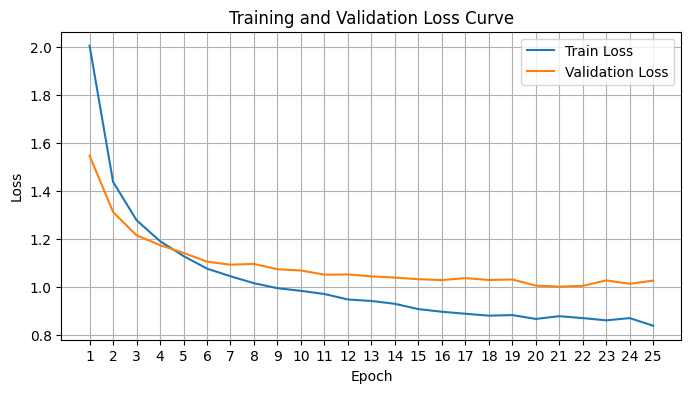

In [21]:
loss_plot(train_losses, val_losses)

Теперь мы перезагрузим модель в ноутбук и прогоним её уже на 20 эпохах с тем же learning rate.

In [25]:
model_training(model, 1, 20, 'check', 0.01)

Epoch 1/20
Train Loss: 2.0010, Train Accuracy: 0.4283
Validation Loss: 1.5044, Validation Accuracy: 0.5736


Epoch 2/20
Train Loss: 1.4172, Train Accuracy: 0.5865
Validation Loss: 1.2819, Validation Accuracy: 0.6133


Epoch 3/20
Train Loss: 1.2689, Train Accuracy: 0.6142
Validation Loss: 1.2007, Validation Accuracy: 0.6293


Epoch 4/20
Train Loss: 1.1803, Train Accuracy: 0.6416
Validation Loss: 1.1502, Validation Accuracy: 0.6446


Epoch 5/20
Train Loss: 1.1184, Train Accuracy: 0.6547
Validation Loss: 1.1213, Validation Accuracy: 0.6461


Epoch 6/20
Train Loss: 1.0688, Train Accuracy: 0.6674
Validation Loss: 1.1084, Validation Accuracy: 0.6549


Epoch 7/20
Train Loss: 1.0521, Train Accuracy: 0.6666
Validation Loss: 1.0708, Validation Accuracy: 0.6599


Epoch 8/20
Train Loss: 1.0081, Train Accuracy: 0.6828
Validation Loss: 1.0745, Validation Accuracy: 0.6658


Epoch 9/20
Train Loss: 0.9864, Train Accuracy: 0.6882
Validation Loss: 1.0651, Validation Accuracy: 0.6668


Epoch 10/20
Train Loss: 0.9693, Train Accuracy: 0.6916
Validation Loss: 1.0499, Validation Accuracy: 0.6655


Epoch 11/20
Train Loss: 0.9664, Train Accuracy: 0.6900
Validation Loss: 1.0475, Validation Accuracy: 0.6664


Epoch 12/20
Train Loss: 0.9395, Train Accuracy: 0.6982
Validation Loss: 1.0286, Validation Accuracy: 0.6749


Epoch 13/20
Train Loss: 0.9345, Train Accuracy: 0.7008
Validation Loss: 1.0398, Validation Accuracy: 0.6680


Epoch 14/20
Train Loss: 0.9002, Train Accuracy: 0.7135
Validation Loss: 1.0498, Validation Accuracy: 0.6646


Epoch 15/20
Train Loss: 0.9114, Train Accuracy: 0.7039
Validation Loss: 1.0381, Validation Accuracy: 0.6739


Epoch 16/20
Train Loss: 0.8934, Train Accuracy: 0.7145
Validation Loss: 1.0268, Validation Accuracy: 0.6708


Epoch 17/20
Train Loss: 0.9050, Train Accuracy: 0.7100
Validation Loss: 1.0312, Validation Accuracy: 0.6649


Epoch 18/20
Train Loss: 0.8875, Train Accuracy: 0.7140
Validation Loss: 1.0223, Validation Accuracy: 0.6593


Epoch 19/20
Train Loss: 0.8808, Train Accuracy: 0.7121
Validation Loss: 1.0216, Validation Accuracy: 0.6799


Epoch 20/20
Train Loss: 0.8578, Train Accuracy: 0.7241
Validation Loss: 1.0231, Validation Accuracy: 0.6687


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

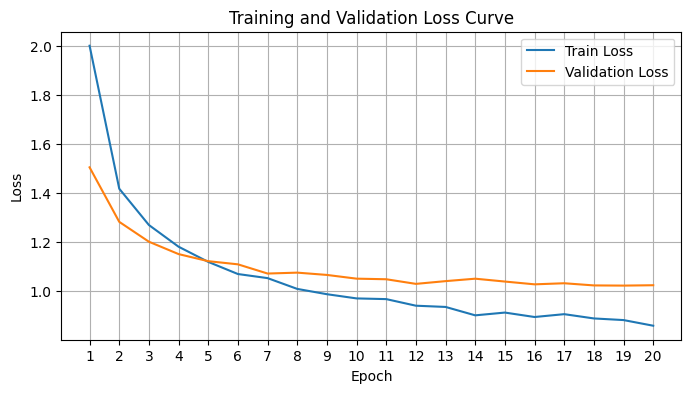

In [26]:
loss_plot(train_losses, val_losses)

Отлично, можно прогнать ещё на 5 эпохах, но уже с `learning rate = 0.001`, чтобы не улететь слишком далеко.

In [29]:
model_training(model, 21, 5, 'final', 0.001)

Epoch 21/25
Train Loss: 0.8411, Train Accuracy: 0.7294
Validation Loss: 1.0161, Validation Accuracy: 0.6805


Epoch 22/25
Train Loss: 0.8333, Train Accuracy: 0.7272
Validation Loss: 1.0256, Validation Accuracy: 0.6602


Epoch 23/25
Train Loss: 0.8450, Train Accuracy: 0.7217
Validation Loss: 1.0199, Validation Accuracy: 0.6687


Epoch 24/25
Train Loss: 0.8438, Train Accuracy: 0.7317
Validation Loss: 1.0121, Validation Accuracy: 0.6743


Epoch 25/25
Train Loss: 0.8400, Train Accuracy: 0.7257
Validation Loss: 1.0253, Validation Accuracy: 0.6699


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

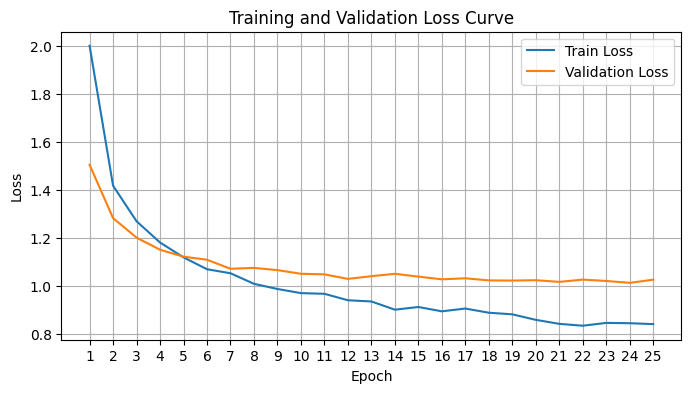

In [30]:
loss_plot(train_losses, val_losses)

Val Loss = 1.0253, Val Accuracy = 0.6699. Для начала нас такой результат устраивает. 

## **5. Тестирование модели**

Теперь можно протестировать модель на тестовой выборке, чтобы посмотреть на промежуточный результат. Заодно сравним `best_model.pth` и `final_model.pth`.

In [19]:
# Загрузка сохраненных весов
def load_w(model):
    model.eval()  # Переводим модель в режим оценки

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return all_labels, all_preds

In [20]:
# Метрики
def metrics(all_labels, all_preds, name):
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')

    print(f'''
== {name}_model =================
Test Accuracy: {accuracy:.4f}
Test F1-Score: {f1:.4f}
Test Recall: {recall:.4f}''')

    # with open(f'test_results_{name}.txt', 'w') as f:
    #     f.write(f"Accuracy: {accuracy:.4f}\n")
    #     f.write(f"F1-Score: {f1:.4f}\n")
    #     f.write(f"Recall: {recall:.4f}\n")
    
    pass

In [33]:
# Confusion Matrix
def conf_matrix(all_labels, all_preds):

    class_names = ["Blazer", "Coat", "Dress", "Hoodie", "Jacket",
        "Jaket_Denim", "Jacket_Sports", "Jeans", "Pants", "Polo",
        "Shirt", "Shorts", "Skirt", "T-shirt", "Sweater"]
    
    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')
    plt.show()
    
    pass

In [22]:
# Список наиболее путающихся классов
import pandas as pd

def most_confused(all_labels, all_preds):
    class_names = ["Blazer", "Coat", "Dress", "Hoodie", "Jacket",
                   "Jaket_Denim", "Jacket_Sports", "Jeans", "Pants", "Polo",
                   "Shirt", "Shorts", "Skirt", "T-shirt", "Sweater"]

    count_dict = defaultdict(int)

    for actual, predicted in zip(all_labels, all_preds):
        count_dict[(actual, predicted)] += 1

    data = []
    for (actual, predicted), amount in count_dict.items():
        data.append((actual, predicted, amount))

    df = pd.DataFrame(data, columns=['actual', 'predicted', 'amount'])

    df['actual'] = df['actual'].apply(lambda x: class_names[x])
    df['predicted'] = df['predicted'].apply(lambda x: class_names[x])

    df_cleared = df[df['actual'] != df['predicted']]

    df_sorted = df_cleared.sort_values(by='amount', ascending=False)

    df_sorted = df_sorted.reset_index(drop=True)
    df_sorted = df_sorted.set_index('actual')
    df_sorted.index.names = [None]

    return df_sorted

In [38]:
model.load_state_dict(torch.load('final_model_final.pth'))
final_all_labels, final_all_preds = load_w(model)

model.load_state_dict(torch.load('best_model_final.pth'))
best_all_labels, best_all_preds = load_w(model)

In [40]:
metrics(final_all_labels, final_all_preds, 'final')
metrics(best_all_labels, best_all_preds, 'best')


== final_model =================
Test Accuracy: 0.6466
Test F1-Score: 0.6441
Test Recall: 0.6466

== best_model =================
Test Accuracy: 0.6555
Test F1-Score: 0.6541
Test Recall: 0.6555


По метрикам best_model лучше, чем final_model, что и ожидалось. Давайте посмотрим матрицу ошибок для best_model.

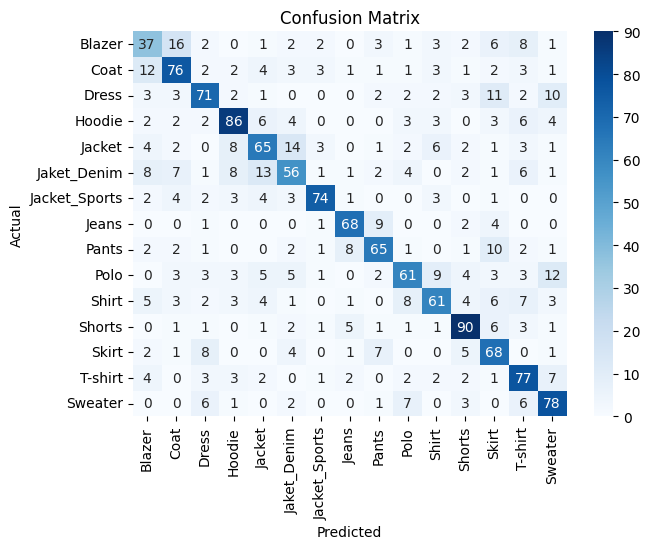

In [41]:
conf_matrix(best_all_labels, best_all_preds)

Теперь посмотрим где чаще всего путается модель. 

In [42]:
most_confused(best_all_labels, best_all_preds).head(10)

,predicted,amount
Blazer,Coat,16
Jacket,Jaket_Denim,14
Jaket_Denim,Jacket,13
Polo,Sweater,12
Coat,Blazer,12
Dress,Skirt,11
Pants,Skirt,10
Dress,Sweater,10
Jeans,Pants,9
Polo,Shirt,9


Как мы видим, в первых 10 местах классы, которые по фотографиям может путать даже человек. Например, некоторые пиджаки ну точь в точь как пальто. Но вцелом, уже неплохо.

## **6. Улучшение модели**

In [ ]:
model.load_state_dict(torch.load('best_model_final.pth'))

Теперь давайте продолжим обучение модели. На этом этапе мы можем добавить ещё одну аугментацию, но в этом случае она будет задействована уже в самом цикле обучения. Также мы можем разморозить ещё несколько слоёв.

Посмотрим же что у нас получится.

#### **Аугментация**

Добавим ещё один вид аугментации. `CutMix` — это метод, который вырезает патчи из одного изображения и вставляет их в другое. Это сохраняет целостность исходных изображений и создает более разнообразные тренировочные образцы. Метки также корректируются в соответствии с площадью вырезанного патча.

In [43]:
def cutmix_data(x, y, alpha=1.0):
    '''__________________________________________________________________________

    torch.randperm(batch_size) создает случайную перестановку индексов от 0 до batch_size - 1.
    Это используется для перемешивания изображений и их меток.
    shuffled_x и shuffled_y - это перемешанные версии исходного батча x и меток y.
    __________________________________________________________________________'''

    batch_size, _, height, width = x.size()
    indices = torch.randperm(batch_size)
    shuffled_x = x[indices]
    shuffled_y = y[indices]

    '''__________________________________________________________________________

    lam - это параметр, который определяет, насколько сильно будет смешано изображение.
    Он выбирается из бета-распределения с параметрами alpha и alpha. Чем больше alpha,
    тем более равномерно будет распределено значение lam.
    __________________________________________________________________________'''

    lam = np.random.beta(alpha, alpha)
    cut_ratio = np.sqrt(1 - lam) # Определяет размер вырезаемой области. 
    cut_width = int(width * cut_ratio)
    cut_height = int(height * cut_ratio)

    # Cлучайные координаты центра вырезаемой области
    cx = np.random.randint(width)
    cy = np.random.randint(height)
    # Левый верхнйи и правый нижний углы
    x1 = int(np.clip(cx - cut_width // 2, 0, width))
    y1 = int(np.clip(cy - cut_height // 2, 0, height))
    x2 = int(np.clip(cx + cut_width // 2, 0, width))
    y2 = int(np.clip(cy + cut_height // 2, 0, height))

    mixed_x = x.clone()
    mixed_x[:, :, y1:y2, x1:x2] = shuffled_x[:, :, y1:y2, x1:x2]
    lam = 1 - ((x2 - x1) * (y2 - y1) / (width * height))
    mixed_y = y * lam + shuffled_y * (1 - lam)

    return mixed_x, mixed_y

#### **Разморозка слоёв**

Разморозим последние несколько слоёв EfficientNet-B0. Это позволит модели адаптироваться к нашим данным, не переобучаясь.

In [56]:
for param in model.features[7].parameters():
    param.requires_grad = True
for param in model.features[8].parameters():
    param.requires_grad = True

In [57]:
print_frozen_layers(model)

1. Слой 'features.0.0.weight' заморожен
2. Слой 'features.0.1.weight' заморожен
3. Слой 'features.0.1.bias' заморожен
4. Слой 'features.1.0.block.0.0.weight' заморожен
5. Слой 'features.1.0.block.0.1.weight' заморожен
6. Слой 'features.1.0.block.0.1.bias' заморожен
7. Слой 'features.1.0.block.1.fc1.weight' заморожен
8. Слой 'features.1.0.block.1.fc1.bias' заморожен
9. Слой 'features.1.0.block.1.fc2.weight' заморожен
10. Слой 'features.1.0.block.1.fc2.bias' заморожен
11. Слой 'features.1.0.block.2.0.weight' заморожен
12. Слой 'features.1.0.block.2.1.weight' заморожен
13. Слой 'features.1.0.block.2.1.bias' заморожен
14. Слой 'features.2.0.block.0.0.weight' заморожен
15. Слой 'features.2.0.block.0.1.weight' заморожен
16. Слой 'features.2.0.block.0.1.bias' заморожен
17. Слой 'features.2.0.block.1.0.weight' заморожен
18. Слой 'features.2.0.block.1.1.weight' заморожен
19. Слой 'features.2.0.block.1.1.bias' заморожен
20. Слой 'features.2.0.block.2.fc1.weight' заморожен
21. Слой 'features.2.0.

Теперь мы можем попробовать дообучить модель на 10 эпохах

#### **Дообучение модели**

In [72]:
def upgrade_model_training(def_model, start, num_epochs, learning_rate):

    best_val_loss = float('inf') 

    optimizer = optim.SGD(def_model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, min_lr=1e-6)

    for epoch in range(start, start + num_epochs):
        def_model.train()
        running_loss = 0.0
        running_accuracy = 0.0

        train_loop = tqdm(train_loader, desc=f"Epoch {epoch}/{start + num_epochs - 1}", leave=False)
        for inputs, labels in train_loop:
            
            # Преобразуем метки в one-hot encoded формат
            labels_one_hot = torch.nn.functional.one_hot(labels, num_classes=15).float()
            
            # Применяем CutMix
            inputs, labels_mixed = cutmix_data(inputs, labels_one_hot)
            
            optimizer.zero_grad()
            outputs = def_model(inputs)
            
            # Преобразуем mixed метки обратно в индексы классов
            labels_indices = labels_mixed.argmax(dim=1)
            
            # Вычисляем loss
            loss = criterion(outputs, labels_indices)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(def_model.parameters(), 1.0)
            optimizer.step()

            running_loss += loss.item()
            running_accuracy += accuracy_score(labels_indices.cpu().numpy(), outputs.argmax(dim=1).cpu().numpy())
            train_loop.set_postfix(loss=loss.item())

        train_loss = running_loss / len(train_loader)
        train_accuracy = running_accuracy / len(train_loader)
        train_losses.append(train_loss)  # Для графика

        # Валидация
        def_model.eval()
        val_loss = 0.0
        val_accuracy = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = def_model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_accuracy += accuracy_score(labels.cpu().numpy(), outputs.argmax(dim=1).cpu().numpy())

        val_loss /= len(val_loader)
        val_accuracy /= len(val_loader)
        val_losses.append(val_loss)  # Для графика

        # Обновление шедулера
        scheduler.step(val_loss)

        # Ранняя остановка
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
            torch.save(def_model.state_dict(), 'best_model_finetuned.pth')
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= early_stopping_patience:
                print(f"Ранняя остановка на эпохе {epoch + 1}")
                break

        print(f"Epoch {epoch}/{start + num_epochs - 1}")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Сохранение финальной модели
    torch.save(def_model.state_dict(), 'final_model_finetuned.pth')

In [ ]:
upgrade_model_training(model, 1, 10, 0.01)

Fine-tuning Epoch 1/10
Train Loss: 1.6391, Train Accuracy: 0.4906
Validation Loss: 0.9471, Validation Accuracy: 0.6852


Fine-tuning Epoch 2/10
Train Loss: 1.5039, Train Accuracy: 0.5266
Validation Loss: 0.9092, Validation Accuracy: 0.7064


Fine-tuning Epoch 3/10
Train Loss: 1.4279, Train Accuracy: 0.5480
Validation Loss: 0.8673, Validation Accuracy: 0.7224


Fine-tuning Epoch 4/10
Train Loss: 1.3784, Train Accuracy: 0.5668
Validation Loss: 0.8317, Validation Accuracy: 0.7318


Fine-tuning Epoch 5/10
Train Loss: 1.2826, Train Accuracy: 0.5950
Validation Loss: 0.8265, Validation Accuracy: 0.7355


Fine-tuning Epoch 6/10
Train Loss: 1.2901, Train Accuracy: 0.5927
Validation Loss: 0.8121, Validation Accuracy: 0.7299


Fine-tuning Epoch 7/10
Train Loss: 1.1899, Train Accuracy: 0.6263
Validation Loss: 0.7959, Validation Accuracy: 0.7296


Fine-tuning Epoch 8/10
Train Loss: 1.2262, Train Accuracy: 0.6187
Validation Loss: 0.7896, Validation Accuracy: 0.7424


Fine-tuning Epoch 9/10
Train Loss: 1.1315, Train Accuracy: 0.6473
Validation Loss: 0.7566, Validation Accuracy: 0.7537


Fine-tuning Epoch 10/10
Train Loss: 1.1292, Train Accuracy: 0.6458
Validation Loss: 0.7529, Validation Accuracy: 0.7627


In [73]:
upgrade_model_training(model, 11, 10, 0.005)

Epoch 11/20
Train Loss: 1.1011, Train Accuracy: 0.6570
Validation Loss: 0.7380, Validation Accuracy: 0.7639


Epoch 12/20
Train Loss: 1.0061, Train Accuracy: 0.6865
Validation Loss: 0.7271, Validation Accuracy: 0.7649


Epoch 13/20
Train Loss: 1.1184, Train Accuracy: 0.6504
Validation Loss: 0.7155, Validation Accuracy: 0.7712


Epoch 14/20
Train Loss: 1.0213, Train Accuracy: 0.6826
Validation Loss: 0.7112, Validation Accuracy: 0.7705


Epoch 15/20
Train Loss: 1.0562, Train Accuracy: 0.6749
Validation Loss: 0.7199, Validation Accuracy: 0.7724


Epoch 16/20
Train Loss: 0.9928, Train Accuracy: 0.6869
Validation Loss: 0.7053, Validation Accuracy: 0.7774


Epoch 17/20
Train Loss: 0.9719, Train Accuracy: 0.7002
Validation Loss: 0.7040, Validation Accuracy: 0.7730


Epoch 18/20
Train Loss: 1.0161, Train Accuracy: 0.6864
Validation Loss: 0.6999, Validation Accuracy: 0.7821


Epoch 19/20
Train Loss: 1.0431, Train Accuracy: 0.6771
Validation Loss: 0.6861, Validation Accuracy: 0.7824


Epoch 20/20
Train Loss: 0.9655, Train Accuracy: 0.6962
Validation Loss: 0.6822, Validation Accuracy: 0.7837


На этом этапе мы уже получили хорошие результаты, которых достаточно, чтобы распознавать бОльшую часть вещей. Но ради эксперимента можно попробовать продвинуться ещё дальше.

In [ ]:
# metrics(final_finetuned_all_preds, final_finetuned_all_labels, 'final')
# metrics(best_finetuned_all_preds, best_finetuned_all_labels, 'best')


== final_model =================
Test Accuracy: 0.7805
Test F1-Score: 0.7799
Test Recall: 0.7805

== best_model =================
Test Accuracy: 0.7805
Test F1-Score: 0.7799
Test Recall: 0.7805


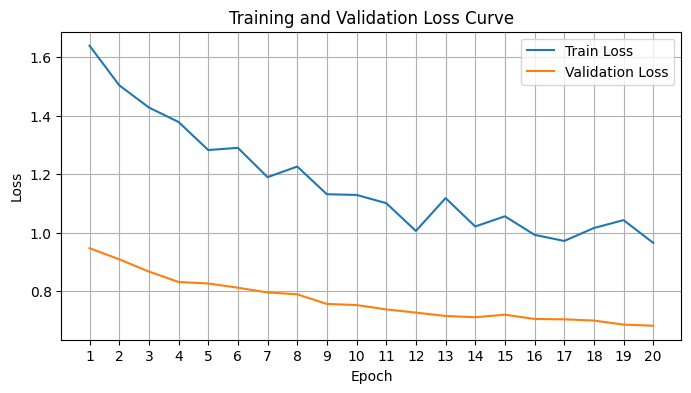

In [11]:
loss_plot(train_losses, val_losses)

Как мы видим на графиках ниже, функции всё ещё стремятся вниз. Так как у нас в функции есть возможность сохранить лучшую, то можем не бояться и снова взять 10 эпох.

По вычитанной информации, лучше не размораживать все слои и остановиться на 2-3 последних, чаще всего даже хватает разморозки только 1 последнего слоя. Поэтому продолжим обучение модели без особых изменений, только ещё раз уменьшим learning rate.

In [78]:
upgrade_model_training(model, 21, 10, 0.001)

Epoch 21/30
Train Loss: 0.9642, Train Accuracy: 0.7014
Validation Loss: 0.6801, Validation Accuracy: 0.7868


Epoch 22/30
Train Loss: 0.9657, Train Accuracy: 0.7015
Validation Loss: 0.6760, Validation Accuracy: 0.7859


Epoch 23/30
Train Loss: 0.9696, Train Accuracy: 0.6990
Validation Loss: 0.6622, Validation Accuracy: 0.7937


Epoch 24/30
Train Loss: 0.9474, Train Accuracy: 0.7069
Validation Loss: 0.6777, Validation Accuracy: 0.7855


Epoch 25/30
Train Loss: 0.9634, Train Accuracy: 0.6972
Validation Loss: 0.6647, Validation Accuracy: 0.7930


Epoch 26/30
Train Loss: 0.8832, Train Accuracy: 0.7286
Validation Loss: 0.6733, Validation Accuracy: 0.7918


Epoch 27/30
Train Loss: 0.9019, Train Accuracy: 0.7184
Validation Loss: 0.6621, Validation Accuracy: 0.7930


Epoch 28/30
Train Loss: 0.9799, Train Accuracy: 0.6938
Validation Loss: 0.6729, Validation Accuracy: 0.7905


Epoch 29/30
Train Loss: 0.9489, Train Accuracy: 0.7059
Validation Loss: 0.6666, Validation Accuracy: 0.7937


Epoch 30/30
Train Loss: 0.9044, Train Accuracy: 0.7221
Validation Loss: 0.6665, Validation Accuracy: 0.7943


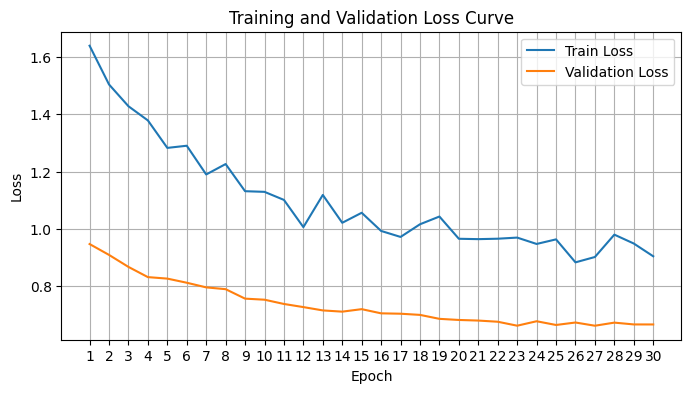

In [13]:
loss_plot(train_losses, val_losses)

Отлично, можно перейти к следующему этапу.

## **7. Повторное тестирование модели**

In [25]:
model.load_state_dict(torch.load('final_model_finetuned.pth'))
final_finetuned_all_preds, final_finetuned_all_labels = load_w(model)

model.load_state_dict(torch.load('best_model_finetuned.pth'))
best_finetuned_all_preds, best_finetuned_all_labels = load_w(model)

In [26]:
# metrics(final_finetuned_all_preds, final_finetuned_all_labels, 'final')
metrics(final_finetuned_all_preds, final_finetuned_all_labels, 'final')
metrics(best_finetuned_all_preds, best_finetuned_all_labels, 'best')


== final_model =================
Test Accuracy: 0.9055
Test F1-Score: 0.9055
Test Recall: 0.9055

== best_model =================
Test Accuracy: 0.9023
Test F1-Score: 0.9021
Test Recall: 0.9023


Мы получили шикарные результаты. Удивительно, что мы получили Accuracy равный `0.9023`, а не `0.7943`. Но грех жаловаться, когда такой отличный результат.

Также, модель записанная в `final_model_finetuned.pth` оказалась лучше, чем `best_model_finetuned.pth`. Не сильно, но всё-таки дальше будем использовать именно её.

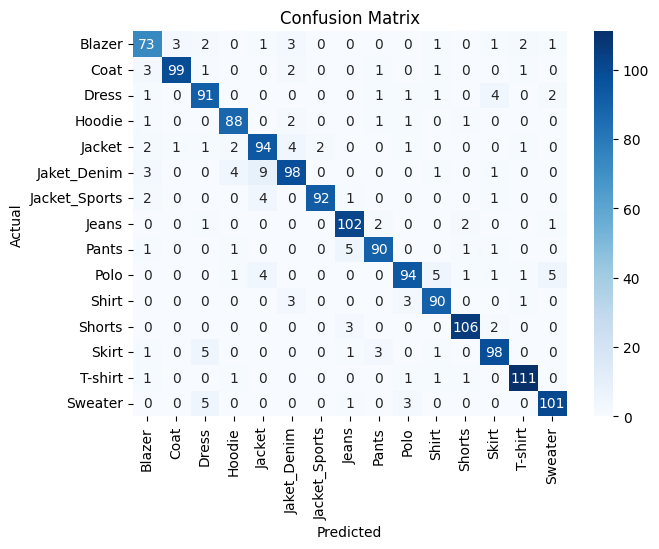

In [34]:
conf_matrix(final_finetuned_all_preds, final_finetuned_all_labels)

Теперь посмотрим где финальная модель путается.

In [32]:
most_confused(final_finetuned_all_preds, final_finetuned_all_labels).head(10)

,predicted,amount
Jaket_Denim,Jacket,9
Polo,Shirt,5
Skirt,Dress,5
Pants,Jeans,5
Polo,Sweater,5
Sweater,Dress,5
Polo,Jacket,4
Jaket_Denim,Hoodie,4
Jacket_Sports,Jacket,4
Jacket,Jaket_Denim,4


## **Завершение**

Теперь можно опробовать нашу обученную модель на наших собственных фотографиях. Для этого мы сделаем небольшое интерактивное веб-приложение с помощью `Streamlit`. Приложение записано в файл: `app.py`. Оно вызывается через консоль.

In [ ]:
# python -m streamlit run app.py

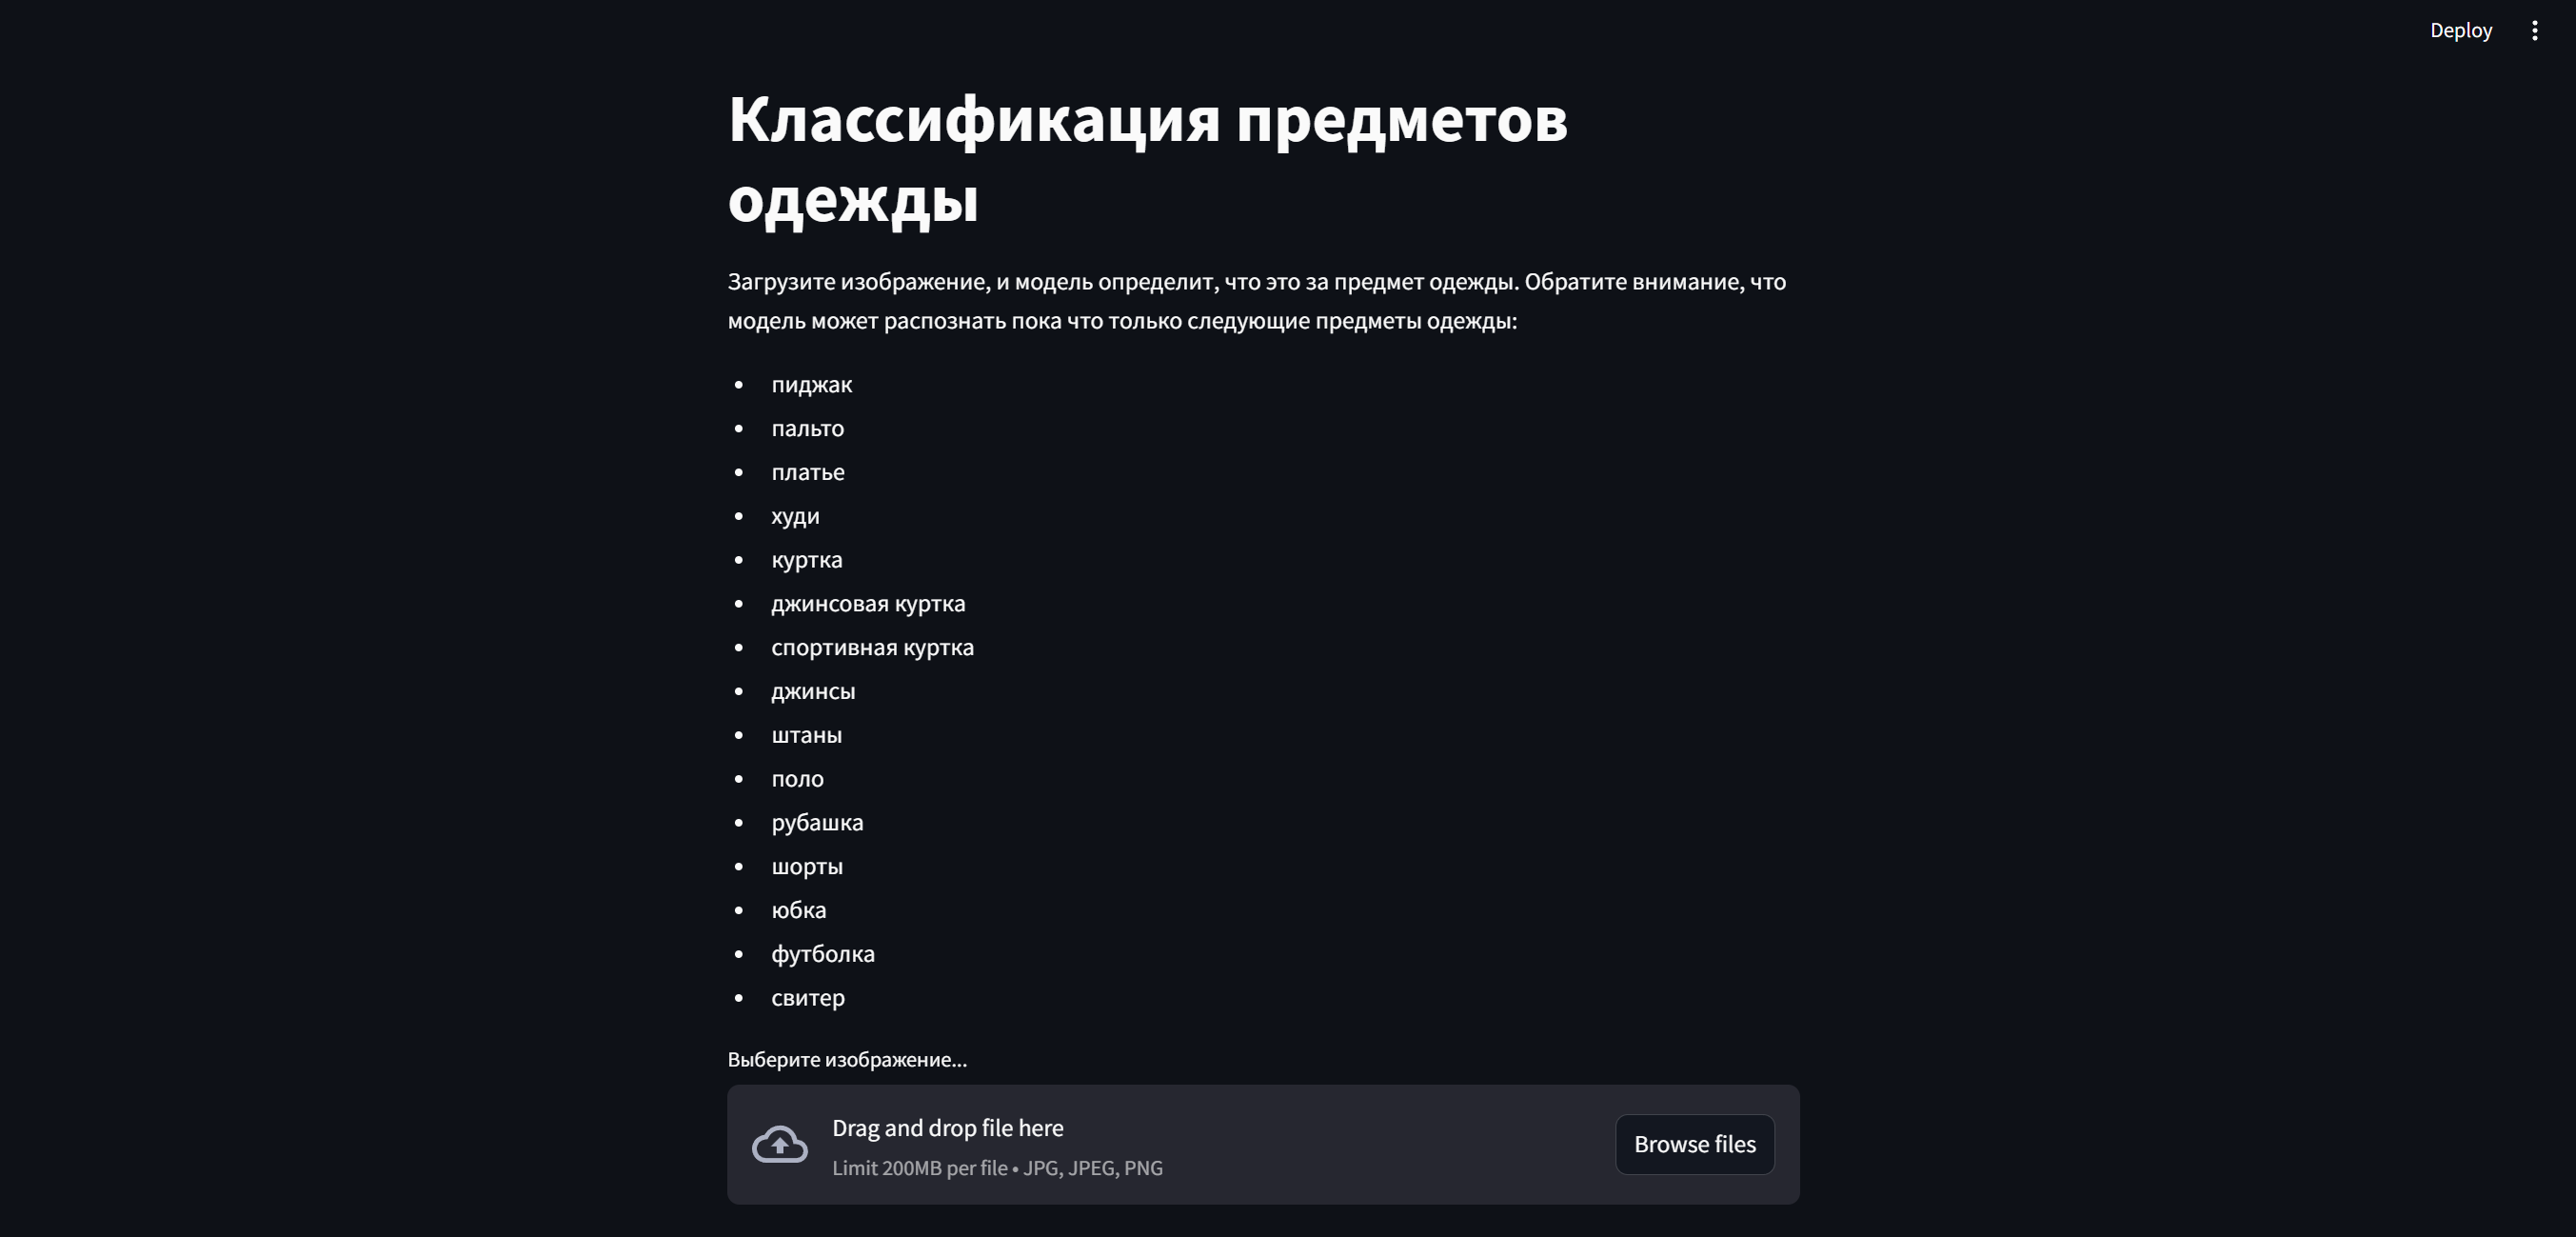

Загружаем фотографии и радуемся какую прекрасную модель мы обучили!

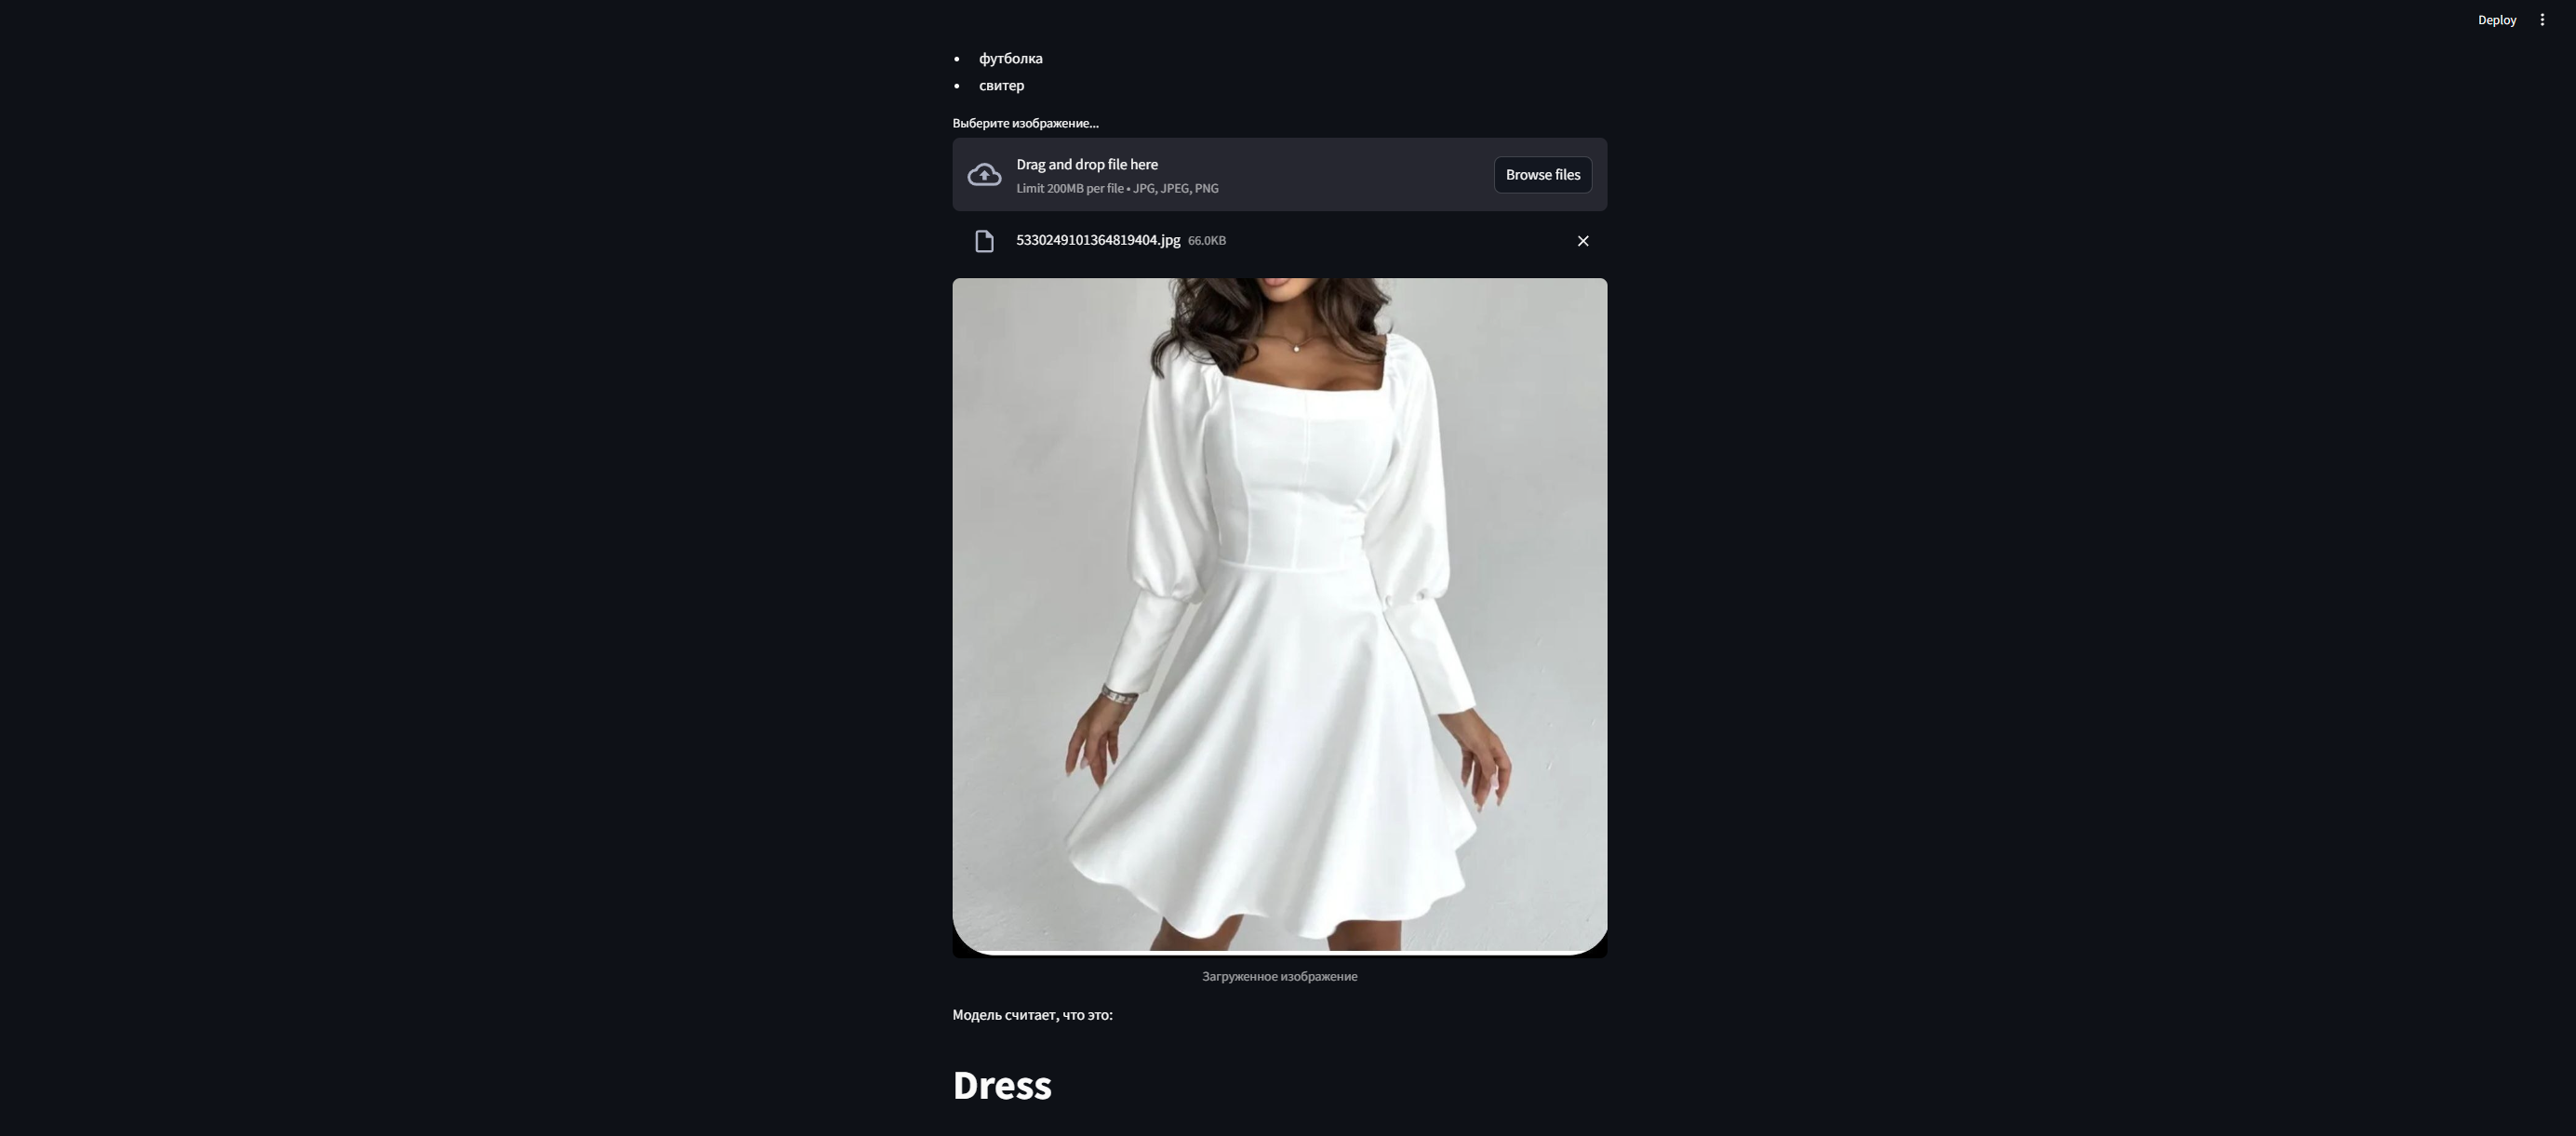

А теперь удаляем все аугментированные изображения из нашего датасета. Нам важно сохранить пользовательские фотографии в исходном состоянии и не заполнять базу данных искусственными изображениями.

In [5]:
data_dir = "Clothes_Dataset"

# Функция для удаления аугментированных изображений
def remove_augmented_images(class_dir):
    files = os.listdir(class_dir)
    
    # Удаляем файлы, начинающиеся с "aug_"
    for file_name in files:
        if file_name.startswith("aug_") and file_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            file_path = os.path.join(class_dir, file_name)
            os.remove(file_path)

# Проходим по всем папкам с классами
for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    if os.path.isdir(class_dir):
        print(f"Удаляем аугментированные изображения для класса: {class_name}")
        remove_augmented_images(class_dir)

print(f'''
================================================
Удаление аугментированных изображений завершено!
================================================''')

Удаляем аугментированные изображения для класса: Blazer
Удаляем аугментированные изображения для класса: Coat
Удаляем аугментированные изображения для класса: Dress
Удаляем аугментированные изображения для класса: Hoodie
Удаляем аугментированные изображения для класса: Jacket
Удаляем аугментированные изображения для класса: Jacket_Sports
Удаляем аугментированные изображения для класса: Jaket_Denim
Удаляем аугментированные изображения для класса: Jeans
Удаляем аугментированные изображения для класса: Pants
Удаляем аугментированные изображения для класса: Polo
Удаляем аугментированные изображения для класса: Shirt
Удаляем аугментированные изображения для класса: Shorts
Удаляем аугментированные изображения для класса: Skirt
Удаляем аугментированные изображения для класса: Sweater
Удаляем аугментированные изображения для класса: T-shirt

Удаление аугментированных изображений завершено!


## **Дополнительно**

В будущем этот код будет использоваться для создания приложения. Поэтому датасет был выбран не случайно :)

Вот что можно будет использовать в перспективе:

**1. <a href="http://mmlab.ie.cuhk.edu.hk/projects/DeepFashion.html">Набор данных DeepFashion</a>.** В будущем, для дальшей работы можно будет использовать этот датасет - огромную базу данных для предсказания категории и атрибутов одежды, собранную Лабораторией Мультимедия Китайского университета в Гонконге. В этом наборе данных уже 46 классов и суммарно 289.222 разнообразных изображений.

**2. Использование методов continual learning.** Continual learning позволяет модели постоянно обучаться на новых данных без "забывания" старых знаний. Это особенно полезно, если данные поступают постепенно.

**3. Активное обучение (Active Learning)** — это подход, при котором модель сама выбирает, какие данные ей нужно дообучить, чтобы улучшить свою производительность.

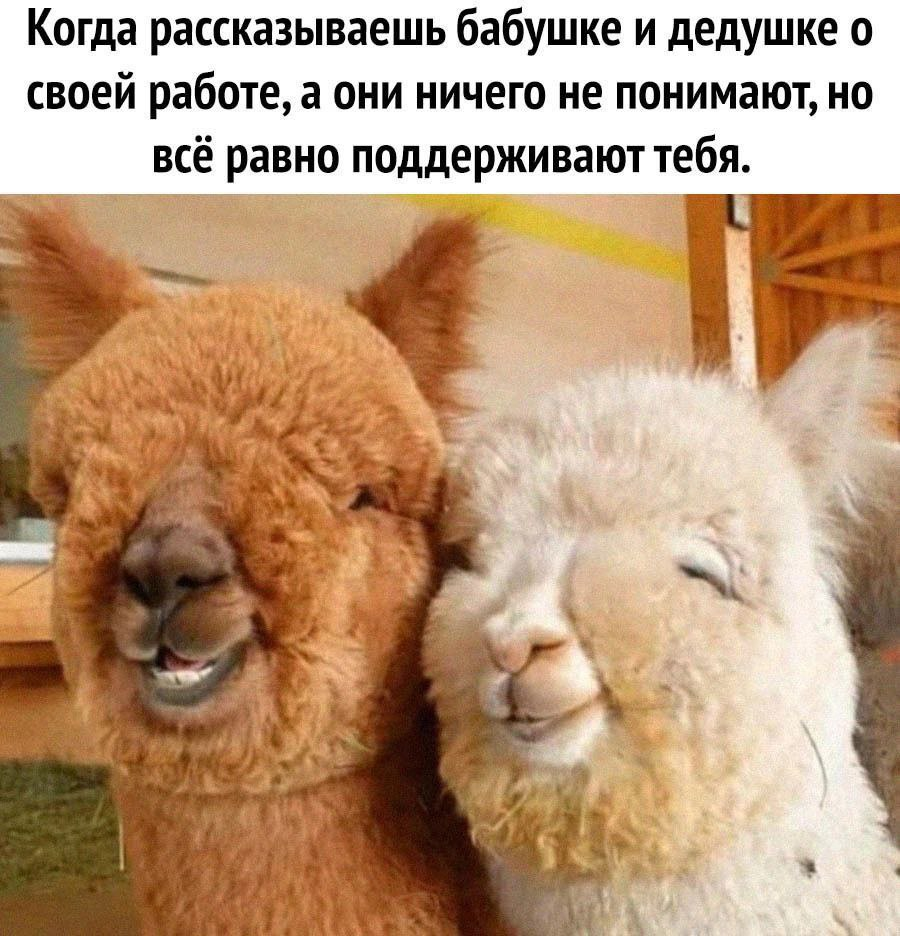